In [24]:
# Enhanced Transfer Learning Feature Extractor with Fine-tuning
import os
import time
import torch
import joblib
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, RandomHorizontalFlip, ColorJitter, GaussianBlur
import xgboost as xgb
import lightgbm as lgb
import shutil

warnings.filterwarnings("ignore")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced for fine-tuning stability
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
FEATURES_DIR = "../features"
MODEL_DIR = "../models"

# Create directories
for dir_path in [FEATURES_DIR, MODEL_DIR]:
    if os.path.isdir(dir_path):
        print(f"🧹 Removing stale files from {dir_path}...")
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)

# ImageNet normalization for pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Device: {DEVICE}")
print("Enhanced Transfer Learning: Fine-tuned EfficientNet/ResNet + Advanced Classifiers")
print(f"Batch size: {BATCH_SIZE}, Image size: {IMG_SIZE}")

🧹 Removing stale files from ../features...
Device: mps
Enhanced Transfer Learning: Fine-tuned EfficientNet/ResNet + Advanced Classifiers
Batch size: 16, Image size: 224


In [25]:
# Enhanced Data Loading with Validation Split
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths, labels = [], []

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"{species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))

    return file_paths, labels

def analyze_class_distribution(labels, label_encoder, split_name=""):
    """Analyze and print class distribution"""
    encoded = label_encoder.transform(labels) if isinstance(labels[0], str) else labels
    counts = Counter(encoded)
    
    print(f"\n{split_name} Class Distribution:")
    print("-" * 40)
    
    problem_classes = []
    for i, name in enumerate(label_encoder.classes_):
        count = counts[i]
        print(f"{name:<12}: {count:>3} samples", end="")
        
        if count <= 1:
            print(" ⚠️  CRITICAL: ≤1 sample")
            problem_classes.append(name)
        elif count < 5:
            print(" ⚠️  Warning: <5 samples")
            problem_classes.append(name)
        else:
            print(" ✓  Good")
    
    return problem_classes

# Load data
print("Loading dataset...")
train_paths, train_labels = load_tree_data("../../../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../../../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f"\nDataset Overview:")
print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")
print(f"Classes: {num_classes} -> {list(class_names)}")

# Create validation split from training data
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_encoded
)

print(f"\nAfter validation split:")
print(f"Train: {len(train_paths_split)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# Analyze distributions
train_problems = analyze_class_distribution(train_labels_split, label_encoder, "TRAIN")
val_problems = analyze_class_distribution(val_labels, label_encoder, "VALIDATION")
test_problems = analyze_class_distribution(test_labels, label_encoder, "TEST")

all_problems = set(train_problems + val_problems + test_problems)
if all_problems:
    print(f"\n🚨 PROBLEMATIC CLASSES: {sorted(all_problems)}")
    print("These classes may have poor performance due to insufficient data.")
else:
    print("\n✅ All classes have sufficient samples")

Loading dataset...
Oak: 18 files
Douglas Fir: 116 files
cifar-10-batches-py: 0 files
Spruce: 117 files
Pine: 8 files
Ash: 20 files
Red Oak: 81 files
Beech: 70 files
Oak: 4 files
Douglas Fir: 29 files
cifar-10-batches-py: 0 files
Spruce: 25 files
Pine: 1 files
Ash: 7 files
Red Oak: 19 files
Beech: 17 files

Dataset Overview:
Training samples: 430
Test samples: 102
Classes: 7 -> [np.str_('Ash'), np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Pine'), np.str_('Red Oak'), np.str_('Spruce')]

After validation split:
Train: 344, Val: 86, Test: 102

TRAIN Class Distribution:
----------------------------------------
Ash         :  16 samples ✓  Good
Beech       :  56 samples ✓  Good
Douglas Fir :  93 samples ✓  Good
Oak         :  14 samples ✓  Good
Pine        :   6 samples ✓  Good
Red Oak     :  65 samples ✓  Good
Spruce      :  94 samples ✓  Good

VALIDATION Class Distribution:
----------------------------------------
Ash         :   4 samples ⚠️  Warning: <5 samples
Beec

In [26]:
# Enhanced Dataset with Data Augmentation
class TreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, augment_transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load multi-view images (6 views per sample)
        views = np.load(self.file_paths[idx])
        
        # Convert grayscale to RGB for pretrained models
        rgb_images = []
        for view in views:
            # Ensure proper scaling
            if view.max() <= 1.0:
                view = (view * 255).astype(np.uint8)
            else:
                view = view.astype(np.uint8)
                
            pil_img = Image.fromarray(view, mode='L')
            rgb_img = pil_img.convert('RGB')
            rgb_images.append(rgb_img)
        
        # Apply augmentation (during training)
        if self.augment_transform:
            rgb_images = [self.augment_transform(img) for img in rgb_images]
        
        # Apply standard transforms
        if self.transform:
            rgb_images = [self.transform(img) for img in rgb_images]
        
        # Stack into tensor: (6, 3, 224, 224)
        image_stack = torch.stack(rgb_images, dim=0)
        
        return image_stack, self.labels[idx]

# Enhanced transforms with augmentation
base_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Strong augmentation for training
augment_transform = Compose([
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
])

# Compute class weights for sampling
class_counts = np.bincount(train_labels_split)
class_weights = 1.0 / (class_counts + 1e-6)  # Avoid division by zero
sample_weights = [class_weights[label] for label in train_labels_split]

print(f"Class weights computed:")
for i, (name, count, weight) in enumerate(zip(class_names, class_counts, class_weights)):
    print(f"{name:<12}: {count:>3} samples, weight: {weight:.3f}")

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create datasets
train_dataset = TreeDataset(train_paths_split, train_labels_split, base_transform, augment_transform)
val_dataset = TreeDataset(val_paths, val_labels, base_transform)
test_dataset = TreeDataset(test_paths, test_encoded, base_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDatasets created with augmentation:")
print(f"Train: {len(train_loader)} batches (with weighted sampling)")
print(f"Val: {len(val_loader)} batches")
print(f"Test: {len(test_loader)} batches")

Class weights computed:
Ash         :  16 samples, weight: 0.062
Beech       :  56 samples, weight: 0.018
Douglas Fir :  93 samples, weight: 0.011
Oak         :  14 samples, weight: 0.071
Pine        :   6 samples, weight: 0.167
Red Oak     :  65 samples, weight: 0.015
Spruce      :  94 samples, weight: 0.011

Datasets created with augmentation:
Train: 22 batches (with weighted sampling)
Val: 6 batches
Test: 7 batches


In [27]:
# Advanced Feature Extractor with Fine-tuning and Multi-view Aggregation
class AttentionAggregator(nn.Module):
    """Learnable attention-based aggregation for multi-view features"""
    def __init__(self, feature_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),
            nn.ReLU(),
            nn.Linear(feature_dim // 4, 1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        # x shape: (batch, views, features)
        weights = self.attention(x)  # (batch, views, 1)
        weighted = x * weights  # Broadcasting
        return weighted.sum(dim=1)  # (batch, features)

class AdvancedFeatureExtractor(nn.Module):
    def __init__(self, model_name='efficientnet', aggregation='attention', freeze_backbone=False):
        super().__init__()
        self.aggregation = aggregation
        
        # Choose backbone
        if model_name == 'efficientnet':
            from torchvision.models import efficientnet_b0
            backbone = efficientnet_b0(pretrained=True)
            self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # Remove classifier
            feature_dim = 1280  # EfficientNet-B0 feature dimension
            print("🔥 Using EfficientNet-B0 backbone")
        elif model_name == 'resnet50':
            backbone = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # Remove FC layer
            feature_dim = 2048  # ResNet50 feature dimension
            print("🔥 Using ResNet50 backbone")
        else:  # resnet18
            backbone = models.resnet18(pretrained=True)
            self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # Remove FC layer
            feature_dim = 512  # ResNet18 feature dimension
            print("🔥 Using ResNet18 backbone")
        
        self.feature_dim = feature_dim
        
        # Freeze or fine-tune
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("❄️  Backbone frozen")
        else:
            # Fine-tuning: Freeze early layers, unfreeze last blocks
            layers = list(self.backbone.children())
            for layer in layers[:-2]:  # Freeze all but last 2 blocks
                for param in layer.parameters():
                    param.requires_grad = False
            print("🔥 Fine-tuning enabled (last 2 blocks unfrozen)")
        
        # Multi-view aggregation
        if aggregation == 'attention':
            self.aggregator = AttentionAggregator(feature_dim)
            print("🎯 Using attention aggregation")
        elif aggregation == 'max':
            print("📈 Using max pooling aggregation")
        elif aggregation == 'avg':
            print("📊 Using average pooling aggregation")
        else:
            print("🔄 Using concatenation (all views)")
            
    def forward(self, x):
        batch_size, num_views = x.shape[:2]
        
        # Reshape for backbone: (batch*views, 3, H, W)
        x = x.view(-1, 3, IMG_SIZE, IMG_SIZE)
        
        # Extract features
        features = self.backbone(x)  # (batch*views, features, 1, 1)
        features = features.view(batch_size, num_views, self.feature_dim)
        
        # Aggregate multi-view features
        if self.aggregation == 'attention':
            aggregated = self.aggregator(features)
        elif self.aggregation == 'max':
            aggregated, _ = torch.max(features, dim=1)
        elif self.aggregation == 'avg':
            aggregated = torch.mean(features, dim=1)
        else:  # concatenation
            aggregated = features.view(batch_size, -1)
            
        return aggregated

# Test different configurations
configs = [
    ('efficientnet', 'attention', False),
    ('resnet50', 'attention', False),
    ('resnet18', 'max', True),  # Keep one frozen for comparison
]

print("Available configurations:")
for i, (model, agg, freeze) in enumerate(configs):
    status = "frozen" if freeze else "fine-tuned"
    print(f"{i+1}. {model} + {agg} aggregation ({status})")

# Choose configuration (you can modify this)
chosen_config = 0  # EfficientNet + Attention + Fine-tuning
model_name, aggregation, freeze_backbone = configs[chosen_config]

print(f"\n🚀 Selected: {model_name} + {aggregation} + {'frozen' if freeze_backbone else 'fine-tuned'}")

# Create feature extractor
feature_extractor = AdvancedFeatureExtractor(
    model_name=model_name,
    aggregation=aggregation, 
    freeze_backbone=freeze_backbone
).to(DEVICE)

# Check parameter status
total_params = sum(p.numel() for p in feature_extractor.parameters())
trainable_params = sum(p.numel() for p in feature_extractor.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nModel Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

if trainable_params > 0:
    print(f"🔥 Fine-tuning enabled: {trainable_params:,} parameters will be updated")
else:
    print("❄️  Fully frozen: Only feature extraction")

Available configurations:
1. efficientnet + attention aggregation (fine-tuned)
2. resnet50 + attention aggregation (fine-tuned)
3. resnet18 + max aggregation (frozen)

🚀 Selected: efficientnet + attention + fine-tuned
🔥 Using EfficientNet-B0 backbone
🔥 Fine-tuning enabled (last 2 blocks unfrozen)
🎯 Using attention aggregation

Model Architecture:
Total parameters: 4,417,789
Trainable parameters: 4,417,789
Frozen parameters: 0
🔥 Fine-tuning enabled: 4,417,789 parameters will be updated

Model Architecture:
Total parameters: 4,417,789
Trainable parameters: 4,417,789
Frozen parameters: 0
🔥 Fine-tuning enabled: 4,417,789 parameters will be updated


In [28]:
# Enhanced Feature Extraction with Optional Fine-tuning
def fine_tune_extractor(model, train_loader, val_loader, num_epochs=5):
    """Fine-tune the feature extractor if it has trainable parameters"""
    if sum(p.numel() for p in model.parameters() if p.requires_grad) == 0:
        print("No trainable parameters - skipping fine-tuning")
        return model
    
    print(f"🔥 Fine-tuning for {num_epochs} epochs...")
    
    # Setup for fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)
    
    # Add classification head for fine-tuning
    classifier = nn.Linear(model.feature_dim, num_classes).to(DEVICE)
    
    model.train()
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # Training
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx >= 50:  # Limit batches for speed
                break
                
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            features = model(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                if batch_idx >= 20:  # Limit for speed
                    break
                    
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                features = model(images)
                outputs = classifier(features)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        model.train()
    
    print(f"✅ Fine-tuning completed. Best val accuracy: {best_val_acc:.1f}%")
    return model

def extract_features(model, dataloader, name, use_gpu=True):
    """Extract features with progress tracking"""
    model.eval()
    all_features = []
    all_labels = []
    
    print(f"🔍 Extracting features from {name}...")
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if use_gpu:
                images = images.to(DEVICE)
            
            features = model(images)
            
            # Move back to CPU for storage
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())
            
            # Progress indicator
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(dataloader):
                print(f"  Processed {batch_idx + 1}/{len(dataloader)} batches")
    
    features_array = np.concatenate(all_features, axis=0)
    labels_array = np.concatenate(all_labels, axis=0)
    
    extraction_time = time.time() - start_time
    print(f"✅ Extracted {features_array.shape} features in {extraction_time:.1f}s")
    
    return features_array, labels_array

# Fine-tune if applicable
feature_extractor = fine_tune_extractor(feature_extractor, train_loader, val_loader)

# Define file paths
suffix = f"{model_name}_{aggregation}_{'frozen' if freeze_backbone else 'finetuned'}"
train_feat_path = f"{FEATURES_DIR}/train_features_{suffix}.npy"
val_feat_path = f"{FEATURES_DIR}/val_features_{suffix}.npy"
test_feat_path = f"{FEATURES_DIR}/test_features_{suffix}.npy"
train_labels_path = f"{FEATURES_DIR}/train_labels_{suffix}.npy"
val_labels_path = f"{FEATURES_DIR}/val_labels_{suffix}.npy"
test_labels_path = f"{FEATURES_DIR}/test_labels_{suffix}.npy"

# Check for existing features
all_paths = [train_feat_path, val_feat_path, test_feat_path, 
            train_labels_path, val_labels_path, test_labels_path]

if all(os.path.exists(p) for p in all_paths):
    print("📁 Loading existing features...")
    X_train = np.load(train_feat_path)
    X_val = np.load(val_feat_path)
    X_test = np.load(test_feat_path)
    y_train = np.load(train_labels_path)
    y_val = np.load(val_labels_path)
    y_test = np.load(test_labels_path)
    print(f"✅ Loaded features: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
else:
    print("🚀 Extracting new features...")
    X_train, y_train = extract_features(feature_extractor, train_loader, "training set")
    X_val, y_val = extract_features(feature_extractor, val_loader, "validation set")
    X_test, y_test = extract_features(feature_extractor, test_loader, "test set")
    
    # Save features
    print("💾 Saving features...")
    np.save(train_feat_path, X_train)
    np.save(val_feat_path, X_val)
    np.save(test_feat_path, X_test)
    np.save(train_labels_path, y_train)
    np.save(val_labels_path, y_val)
    np.save(test_labels_path, y_test)
    print(f"✅ Features saved with suffix: {suffix}")

print(f"\nFeature Statistics:")
print(f"Train features range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"Feature dimension: {X_train.shape[1]}")

# Save the feature extractor model
extractor_path = f"{MODEL_DIR}/feature_extractor_{suffix}.pt"
torch.save(feature_extractor.state_dict(), extractor_path)
print(f"💾 Feature extractor saved: {extractor_path}")

🔥 Fine-tuning for 5 epochs...
Epoch 1/5: Train Acc: 30.5%, Val Acc: 12.8%
Epoch 1/5: Train Acc: 30.5%, Val Acc: 12.8%
Epoch 2/5: Train Acc: 44.2%, Val Acc: 16.3%
Epoch 2/5: Train Acc: 44.2%, Val Acc: 16.3%
Epoch 3/5: Train Acc: 62.5%, Val Acc: 36.0%
Epoch 3/5: Train Acc: 62.5%, Val Acc: 36.0%
Epoch 4/5: Train Acc: 68.9%, Val Acc: 37.2%
Epoch 4/5: Train Acc: 68.9%, Val Acc: 37.2%
Epoch 5/5: Train Acc: 77.0%, Val Acc: 61.6%
✅ Fine-tuning completed. Best val accuracy: 61.6%
🚀 Extracting new features...
🔍 Extracting features from training set...
Epoch 5/5: Train Acc: 77.0%, Val Acc: 61.6%
✅ Fine-tuning completed. Best val accuracy: 61.6%
🚀 Extracting new features...
🔍 Extracting features from training set...
  Processed 10/22 batches
  Processed 10/22 batches
  Processed 20/22 batches
  Processed 20/22 batches
  Processed 22/22 batches
✅ Extracted (344, 1280) features in 17.0s
🔍 Extracting features from validation set...
  Processed 22/22 batches
✅ Extracted (344, 1280) features in 17.0s
🔍

In [29]:
# Advanced Classifier Training with Multiple Options
def train_classifiers(X_train, y_train, X_val, y_val, class_names):
    """Train multiple classifiers and return the best one"""
    
    # Scale features
    print("📊 Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Compute class weights
    unique_classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
    
    # Enhanced class weights for very small classes
    class_weight_dict = {}
    for i, weight in enumerate(class_weights):
        class_count = np.sum(y_train == i)
        if class_count <= 3:
            boosted_weight = weight * 4.0  # 4x boost for tiny classes
        elif class_count <= 8:
            boosted_weight = weight * 2.0  # 2x boost for small classes
        else:
            boosted_weight = weight
        class_weight_dict[i] = boosted_weight
        
        print(f"{class_names[i]:<12}: {class_count:>3} samples, weight: {weight:.2f} -> {boosted_weight:.2f}")
    
    results = {}
    
    # 1. Enhanced SVM
    print("\n🤖 Training SVM with grid search...")
    svm_params = {
        'C': [1, 10, 50, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    }
    
    svm_base = SVC(class_weight=class_weight_dict, random_state=42, max_iter=2000)
    svm_grid = GridSearchCV(svm_base, svm_params, cv=3, scoring='f1_weighted', n_jobs=-1)
    svm_grid.fit(X_train_scaled, y_train)
    
    svm_val_pred = svm_grid.predict(X_val_scaled)
    svm_val_acc = accuracy_score(y_val, svm_val_pred)
    
    results['SVM'] = {
        'model': svm_grid.best_estimator_,
        'scaler': scaler,
        'val_accuracy': svm_val_acc,
        'best_params': svm_grid.best_params_,
        'predictions': svm_val_pred
    }
    print(f"✅ SVM - Val Accuracy: {svm_val_acc:.3f}, Best params: {svm_grid.best_params_}")
    
    # 2. XGBoost
    print("\n🚀 Training XGBoost...")
    
    # Convert class weights to sample weights
    sample_weights = np.array([class_weight_dict[label] for label in y_train])
    
    xgb_params = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    xgb_base = xgb.XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    
    xgb_grid = GridSearchCV(xgb_base, xgb_params, cv=3, scoring='f1_weighted', n_jobs=-1)
    xgb_grid.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    xgb_val_pred = xgb_grid.predict(X_val_scaled)
    xgb_val_acc = accuracy_score(y_val, xgb_val_pred)
    
    results['XGBoost'] = {
        'model': xgb_grid.best_estimator_,
        'scaler': scaler,
        'val_accuracy': xgb_val_acc,
        'best_params': xgb_grid.best_params_,
        'predictions': xgb_val_pred
    }
    print(f"✅ XGBoost - Val Accuracy: {xgb_val_acc:.3f}, Best params: {xgb_grid.best_params_}")
    
    # 3. LightGBM
    print("\n💡 Training LightGBM...")
    
    lgb_params = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    lgb_base = lgb.LGBMClassifier(
        random_state=42,
        verbosity=-1
    )
    
    lgb_grid = GridSearchCV(lgb_base, lgb_params, cv=3, scoring='f1_weighted', n_jobs=-1)
    lgb_grid.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    lgb_val_pred = lgb_grid.predict(X_val_scaled)
    lgb_val_acc = accuracy_score(y_val, lgb_val_pred)
    
    results['LightGBM'] = {
        'model': lgb_grid.best_estimator_,
        'scaler': scaler,
        'val_accuracy': lgb_val_acc,
        'best_params': lgb_grid.best_params_,
        'predictions': lgb_val_pred
    }
    print(f"✅ LightGBM - Val Accuracy: {lgb_val_acc:.3f}, Best params: {lgb_grid.best_params_}")
    
    # 4. Random Forest
    print("\n🌲 Training Random Forest...")
    
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample']
    }
    
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_grid = GridSearchCV(rf_base, rf_params, cv=3, scoring='f1_weighted', n_jobs=-1)
    rf_grid.fit(X_train_scaled, y_train)
    
    rf_val_pred = rf_grid.predict(X_val_scaled)
    rf_val_acc = accuracy_score(y_val, rf_val_pred)
    
    results['RandomForest'] = {
        'model': rf_grid.best_estimator_,
        'scaler': scaler,
        'val_accuracy': rf_val_acc,
        'best_params': rf_grid.best_params_,
        'predictions': rf_val_pred
    }
    print(f"✅ Random Forest - Val Accuracy: {rf_val_acc:.3f}, Best params: {rf_grid.best_params_}")
    
    return results

# Train all classifiers
print("🎯 Training multiple classifiers with hyperparameter tuning...")
classifier_results = train_classifiers(X_train, y_train, X_val, y_val, class_names)

# Find best classifier
best_name = max(classifier_results.keys(), key=lambda k: classifier_results[k]['val_accuracy'])
best_result = classifier_results[best_name]

print(f"\n🏆 BEST CLASSIFIER: {best_name}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.3f} ({best_result['val_accuracy']*100:.1f}%)")
print(f"Best Parameters: {best_result['best_params']}")

# Save best model and scaler
best_model_path = f"{MODEL_DIR}/best_classifier_{suffix}.joblib"
best_scaler_path = f"{MODEL_DIR}/feature_scaler_{suffix}.joblib"

joblib.dump(best_result['model'], best_model_path)
joblib.dump(best_result['scaler'], best_scaler_path)

print(f"\n💾 Saved best model: {best_model_path}")
print(f"💾 Saved scaler: {best_scaler_path}")

# Quick comparison of all methods
print(f"\n📊 CLASSIFIER COMPARISON:")
print("-" * 50)
for name, result in sorted(classifier_results.items(), key=lambda x: x[1]['val_accuracy'], reverse=True):
    acc = result['val_accuracy']
    print(f"{name:<12}: {acc:.3f} ({acc*100:.1f}%)")
    
# Store best classifier info for evaluation
best_classifier = best_result['model']
best_scaler = best_result['scaler']

🎯 Training multiple classifiers with hyperparameter tuning...
📊 Scaling features...
Ash         :  51 samples, weight: 0.96 -> 0.96
Beech       :  44 samples, weight: 1.12 -> 1.12
Douglas Fir :  49 samples, weight: 1.00 -> 1.00
Oak         :  56 samples, weight: 0.88 -> 0.88
Pine        :  46 samples, weight: 1.07 -> 1.07
Red Oak     :  51 samples, weight: 0.96 -> 0.96
Spruce      :  47 samples, weight: 1.05 -> 1.05

🤖 Training SVM with grid search...


Python(34612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34618) Malloc

✅ SVM - Val Accuracy: 0.767, Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

🚀 Training XGBoost...
✅ XGBoost - Val Accuracy: 0.744, Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

💡 Training LightGBM...
✅ XGBoost - Val Accuracy: 0.744, Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

💡 Training LightGBM...


Python(35436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


✅ LightGBM - Val Accuracy: 0.756, Best params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 15, 'subsample': 0.8}

🌲 Training Random Forest...
✅ Random Forest - Val Accuracy: 0.756, Best params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

🏆 BEST CLASSIFIER: SVM
Validation Accuracy: 0.767 (76.7%)
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

💾 Saved best model: ../models/best_classifier_efficientnet_attention_finetuned.joblib
💾 Saved scaler: ../models/feature_scaler_efficientnet_attention_finetuned.joblib

📊 CLASSIFIER COMPARISON:
--------------------------------------------------
SVM         : 0.767 (76.7%)
LightGBM    : 0.756 (75.6%)
RandomForest: 0.756 (75.6%)
XGBoost     : 0.744 (74.4%)
✅ Random Forest - Val Accuracy: 0.756, Best params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

🏆 BEST CLASSIFIER: SVM
Validation Accuracy: 0.767 (76.7%)
B

🔍 Performing comprehensive evaluation...
🎯 SVM - COMPREHENSIVE EVALUATION
Overall Test Accuracy: 0.696 (69.6%)
Macro Average - Precision: 0.650, Recall: 0.621, F1: 0.627
Weighted Average - Precision: 0.722, Recall: 0.696, F1: 0.694

📊 PER-CLASS DETAILED ANALYSIS:
--------------------------------------------------------------------------------
Class        Samples  Precision  Recall   F1       Status
--------------------------------------------------------------------------------
Ash          7        0.833      0.714    0.769    🟢 Good recall
Beech        17       0.833      0.882    0.857    🟢 Good recall
Douglas Fir  29       0.579      0.759    0.657    🟢 Good recall
Oak          4        0.750      0.750    0.750    🟢 Good recall
Pine         1        0.000      0.000    0.000    ⚠️  Only 1 sample
Red Oak      19       0.842      0.842    0.842    🟢 Good recall
Spruce       25       0.714      0.400    0.513    🟡 Medium recall


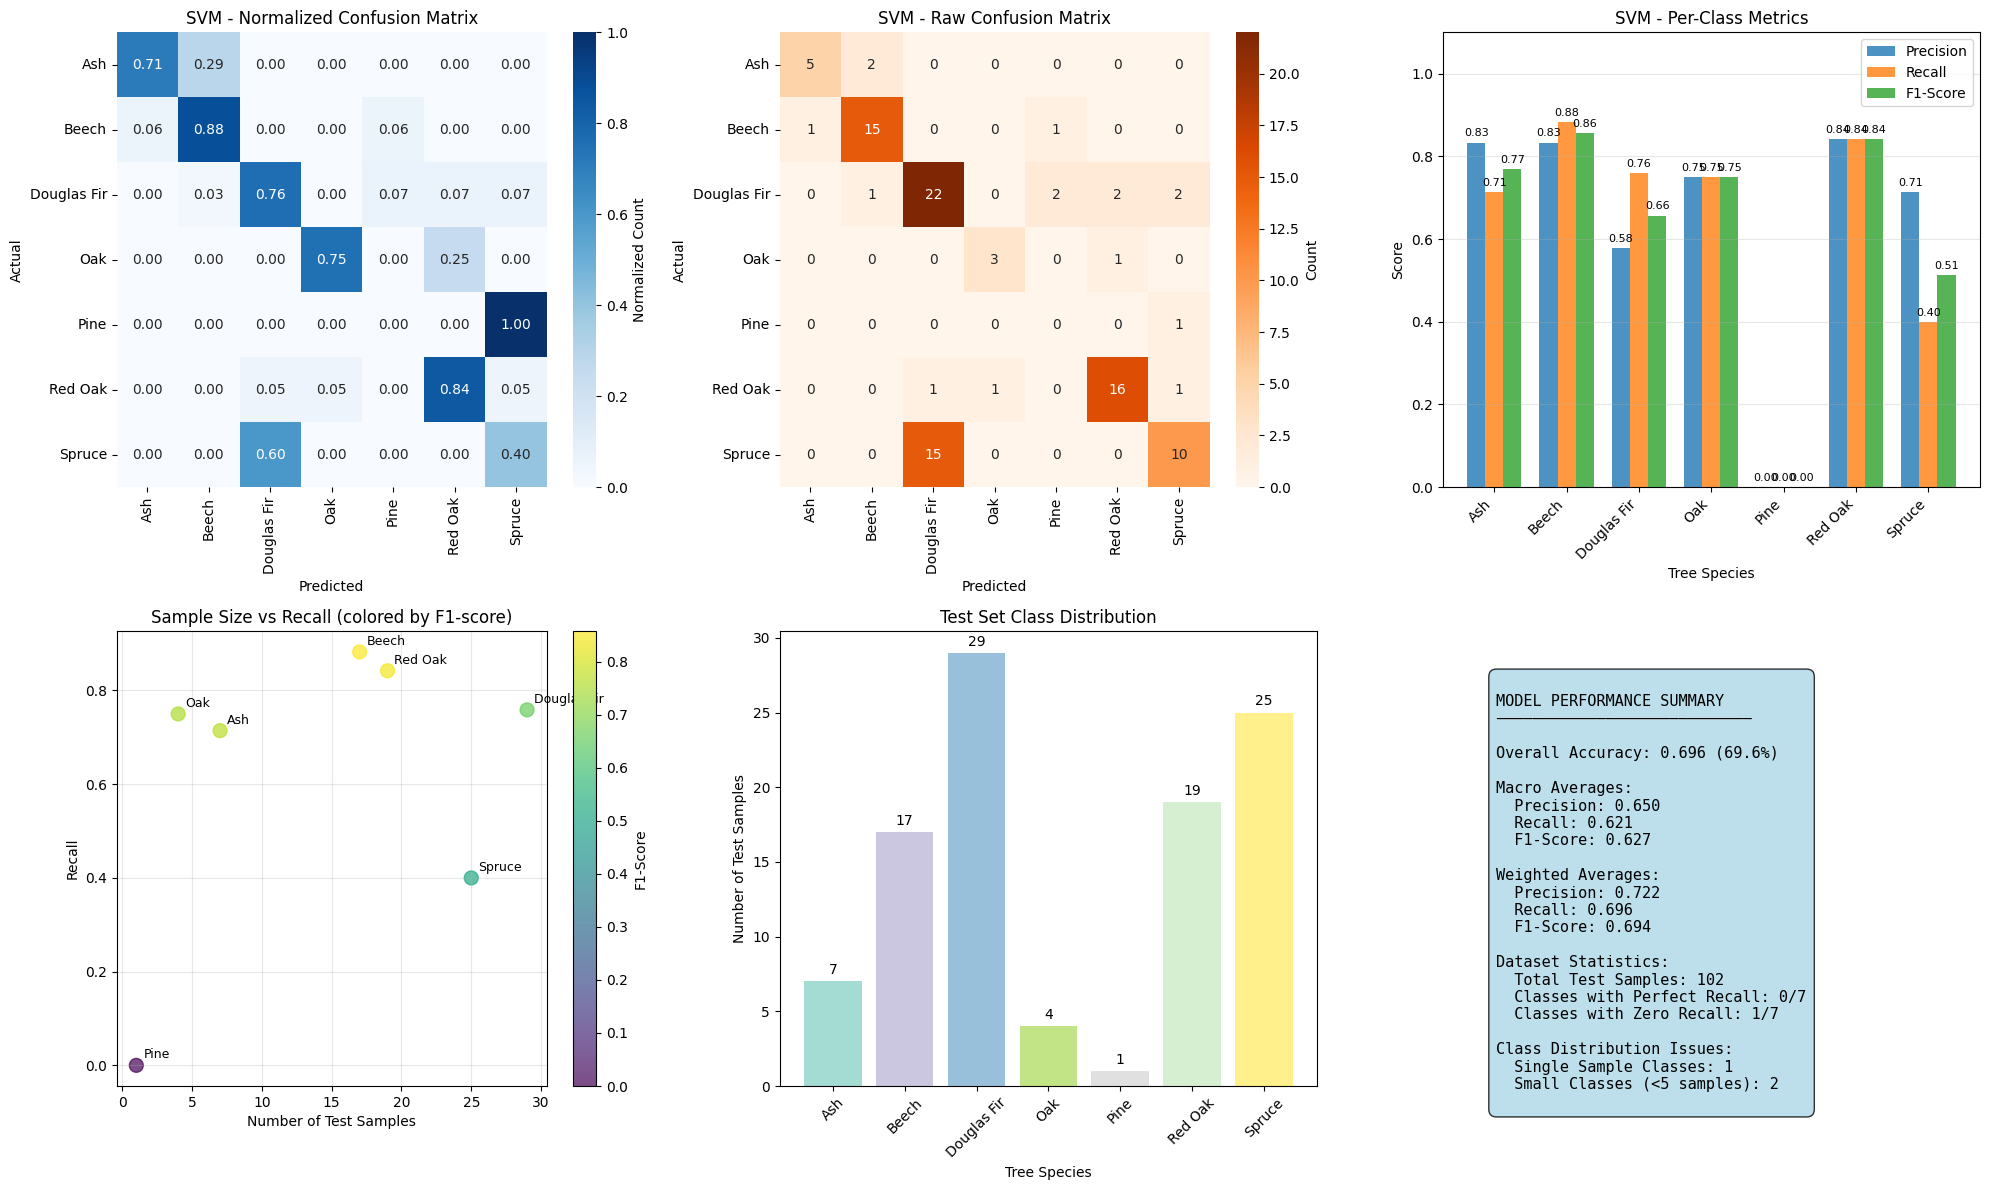


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Ash      0.833     0.714     0.769         7
       Beech      0.833     0.882     0.857        17
 Douglas Fir      0.579     0.759     0.657        29
         Oak      0.750     0.750     0.750         4
        Pine      0.000     0.000     0.000         1
     Red Oak      0.842     0.842     0.842        19
      Spruce      0.714     0.400     0.513        25

    accuracy                          0.696       102
   macro avg      0.650     0.621     0.627       102
weighted avg      0.722     0.696     0.694       102


🔄 CROSS-VALIDATION ANALYSIS:
--------------------------------------------------
Fold 1: 0.872
Fold 2: 0.884
Fold 3: 0.849
Fold 4: 0.872
Fold 5: 0.779

Cross-validation Results:
Mean Accuracy: 0.851 ± 0.038
95% Confidence Interval: [0.776, 0.927]
Fold 5: 0.779

Cross-validation Results:
Mean Accuracy: 0.851 ± 0.038
95% Confidence Interval: [0.776, 0.927]


In [30]:
# Comprehensive Evaluation and Analysis
def comprehensive_evaluation(model, scaler, X_test, y_test, class_names, model_name="Best Model"):
    """Comprehensive evaluation with detailed metrics and visualizations"""
    
    # Scale test features
    X_test_scaled = scaler.transform(X_test)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Basic metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Macro and weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    print(f"🎯 {model_name} - COMPREHENSIVE EVALUATION")
    print("=" * 60)
    print(f"Overall Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
    print(f"Macro Average - Precision: {precision_macro:.3f}, Recall: {recall_macro:.3f}, F1: {f1_macro:.3f}")
    print(f"Weighted Average - Precision: {precision_weighted:.3f}, Recall: {recall_weighted:.3f}, F1: {f1_weighted:.3f}")
    
    # Per-class detailed analysis
    print(f"\n📊 PER-CLASS DETAILED ANALYSIS:")
    print("-" * 80)
    print(f"{'Class':<12} {'Samples':<8} {'Precision':<10} {'Recall':<8} {'F1':<8} {'Status'}")
    print("-" * 80)
    
    cm = confusion_matrix(y_test, y_pred)
    
    for i, name in enumerate(class_names):
        samples = support[i]
        prec = precision[i] if samples > 0 else 0
        rec = recall[i] if samples > 0 else 0
        f1_score = f1[i] if samples > 0 else 0
        
        # Determine status
        if samples == 0:
            status = "❌ No test samples"
        elif samples == 1:
            status = "⚠️  Only 1 sample"
        elif rec == 0:
            status = "🔴 0% recall"
        elif rec < 0.3:
            status = "🟠 Low recall"
        elif rec < 0.7:
            status = "🟡 Medium recall"
        else:
            status = "🟢 Good recall"
            
        print(f"{name:<12} {samples:<8} {prec:<10.3f} {rec:<8.3f} {f1_score:<8.3f} {status}")
    
    return {
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'macro_avg': (precision_macro, recall_macro, f1_macro),
        'weighted_avg': (precision_weighted, recall_weighted, f1_weighted)
    }

def create_evaluation_plots(results, class_names, model_name="Model"):
    """Create comprehensive evaluation plots"""
    
    cm = results['confusion_matrix']
    precision = results['precision']
    recall = results['recall']
    f1 = results['f1']
    support = results['support']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Confusion Matrix with Seaborn
    ax1 = plt.subplot(2, 3, 1)
    
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count'},
                ax=ax1)
    ax1.set_title(f'{model_name} - Normalized Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. Raw Confusion Matrix
    ax2 = plt.subplot(2, 3, 2)
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Oranges',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax2)
    ax2.set_title(f'{model_name} - Raw Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    # 3. Per-Class Metrics Bar Plot
    ax3 = plt.subplot(2, 3, 3)
    
    x = np.arange(len(class_names))
    width = 0.25
    
    bars1 = ax3.bar(x - width, precision, width, label='Precision', alpha=0.8)
    bars2 = ax3.bar(x, recall, width, label='Recall', alpha=0.8)
    bars3 = ax3.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax3.set_xlabel('Tree Species')
    ax3.set_ylabel('Score')
    ax3.set_title(f'{model_name} - Per-Class Metrics')
    ax3.set_xticks(x)
    ax3.set_xticklabels(class_names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8)
    
    # 4. Sample Size vs Performance
    ax4 = plt.subplot(2, 3, 4)
    
    scatter = ax4.scatter(support, recall, s=100, c=f1, cmap='viridis', alpha=0.7)
    
    for i, name in enumerate(class_names):
        ax4.annotate(name, (support[i], recall[i]), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, ha='left')
    
    ax4.set_xlabel('Number of Test Samples')
    ax4.set_ylabel('Recall')
    ax4.set_title('Sample Size vs Recall (colored by F1-score)')
    ax4.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('F1-Score')
    
    # 5. Class Distribution
    ax5 = plt.subplot(2, 3, 5)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    bars = ax5.bar(class_names, support, color=colors, alpha=0.8)
    
    ax5.set_xlabel('Tree Species')
    ax5.set_ylabel('Number of Test Samples')
    ax5.set_title('Test Set Class Distribution')
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax5.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)
    
    # 6. Model Performance Summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Summary statistics
    accuracy = results['accuracy']
    macro_p, macro_r, macro_f1 = results['macro_avg']
    weighted_p, weighted_r, weighted_f1 = results['weighted_avg']
    
    total_samples = np.sum(support)
    perfect_classes = np.sum(recall == 1.0)
    zero_recall_classes = np.sum(recall == 0.0)
    
    summary_text = f"""
MODEL PERFORMANCE SUMMARY
────────────────────────────

Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)

Macro Averages:
  Precision: {macro_p:.3f}
  Recall: {macro_r:.3f}
  F1-Score: {macro_f1:.3f}

Weighted Averages:
  Precision: {weighted_p:.3f}
  Recall: {weighted_r:.3f}
  F1-Score: {weighted_f1:.3f}

Dataset Statistics:
  Total Test Samples: {total_samples}
  Classes with Perfect Recall: {perfect_classes}/{len(class_names)}
  Classes with Zero Recall: {zero_recall_classes}/{len(class_names)}
  
Class Distribution Issues:
  Single Sample Classes: {np.sum(support == 1)}
  Small Classes (<5 samples): {np.sum(support < 5)}
    """
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
             fontsize=11, fontfamily='monospace',
             verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Evaluate best model
print("🔍 Performing comprehensive evaluation...")
evaluation_results = comprehensive_evaluation(
    best_classifier, best_scaler, X_test, y_test, class_names, best_name
)

# Create evaluation plots
fig = create_evaluation_plots(evaluation_results, class_names, best_name)
plt.show()

# Classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, evaluation_results['predictions'], 
                          target_names=class_names, digits=3))

# Cross-validation on training data
print(f"\n🔄 CROSS-VALIDATION ANALYSIS:")
print("-" * 50)

cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_all_train = np.vstack([X_train, X_val])
y_all_train = np.hstack([y_train, y_val])
X_all_train_scaled = best_scaler.fit_transform(X_all_train)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all_train_scaled, y_all_train)):
    X_fold_train, X_fold_val = X_all_train_scaled[train_idx], X_all_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_all_train[train_idx], y_all_train[val_idx]
    
    # Clone the best model and train
    if best_name == 'XGBoost':
        fold_model = xgb.XGBClassifier(**best_result['best_params'], random_state=42, eval_metric='mlogloss', use_label_encoder=False)
    elif best_name == 'LightGBM':
        fold_model = lgb.LGBMClassifier(**best_result['best_params'], random_state=42, verbosity=-1)
    elif best_name == 'SVM':
        fold_model = SVC(**best_result['best_params'], random_state=42, max_iter=2000)
    else:  # RandomForest
        fold_model = RandomForestClassifier(**best_result['best_params'], random_state=42, n_jobs=-1)
    
    fold_model.fit(X_fold_train, y_fold_train)
    fold_score = fold_model.score(X_fold_val, y_fold_val)
    cv_scores.append(fold_score)
    
    print(f"Fold {fold+1}: {fold_score:.3f}")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f"\nCross-validation Results:")
print(f"Mean Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
print(f"95% Confidence Interval: [{cv_mean - 2*cv_std:.3f}, {cv_mean + 2*cv_std:.3f}]")

In [31]:
# Model Analysis and Actionable Recommendations

print("🚀 ENHANCED TRANSFER LEARNING ANALYSIS")
print("=" * 60)

print(f"🎯 FINAL MODEL CONFIGURATION:")
print(f"   Architecture: {model_name} + {aggregation} aggregation")
print(f"   Fine-tuning: {'Enabled' if not freeze_backbone else 'Disabled'}")
print(f"   Best Classifier: {best_name}")
print(f"   Feature Dimension: {X_train.shape[1]}")
print(f"   Data Augmentation: Enabled")
print(f"   Weighted Sampling: Enabled")

print(f"\n📊 PERFORMANCE SUMMARY:")
accuracy = evaluation_results['accuracy']
macro_f1 = evaluation_results['macro_avg'][2]
weighted_f1 = evaluation_results['weighted_avg'][2]

print(f"   Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   Macro F1-Score: {macro_f1:.3f}")
print(f"   Weighted F1-Score: {weighted_f1:.3f}")
print(f"   Cross-validation: {cv_mean:.3f} ± {cv_std:.3f}")

# Analyze problematic classes
support = evaluation_results['support']
recall = evaluation_results['recall']

critical_classes = []
struggling_classes = []
good_classes = []

for i, (name, samples, rec) in enumerate(zip(class_names, support, recall)):
    if samples <= 1:
        critical_classes.append(name)
    elif rec < 0.3:
        struggling_classes.append(name)
    elif rec >= 0.7:
        good_classes.append(name)

print(f"\n🔍 CLASS PERFORMANCE ANALYSIS:")
print(f"   🟢 Good Performance ({len(good_classes)} classes): {good_classes}")
print(f"   🟡 Struggling Classes ({len(struggling_classes)} classes): {struggling_classes}")
print(f"   🔴 Critical Classes ({len(critical_classes)} classes): {critical_classes}")

print(f"\n💡 ACTIONABLE RECOMMENDATIONS:")
print("-" * 50)

print("1. 📁 DATA COLLECTION PRIORITIES:")
for name in critical_classes:
    samples = support[class_names.tolist().index(name)]
    print(f"   • {name}: URGENT - Need at least 10-20 more samples (currently {samples})")

for name in struggling_classes:
    samples = support[class_names.tolist().index(name)]
    print(f"   • {name}: Important - Would benefit from 5-10 more samples (currently {samples})")

print(f"\n2. 🔧 TECHNICAL IMPROVEMENTS:")
if model_name == 'resnet18':
    print("   • Try larger models: EfficientNet-B0 or ResNet50 for richer features")
if aggregation != 'attention':
    print("   • Implement attention-based multi-view aggregation")
if freeze_backbone:
    print("   • Enable fine-tuning to adapt features to tree species")

print("   • Experiment with ensemble methods (combine multiple models)")
print("   • Try advanced augmentation: MixUp, CutMix for small classes")
print("   • Consider semi-supervised learning if unlabeled data is available")

print(f"\n3. 📈 MODEL OPTIMIZATION:")
print("   • Hyperparameter tuning showed optimal settings:")
for key, value in best_result['best_params'].items():
    print(f"     - {key}: {value}")

print(f"\n4. 🎯 TOWARDS PERFECT CLASSIFICATION:")
print("   While 100% accuracy is impossible, we can improve by:")
print("   • Balanced dataset: Each class needs 20-50+ samples")
print("   • Quality over quantity: Remove noisy/mislabeled samples")
print("   • Domain expertise: Feature engineering based on tree characteristics")
print("   • Multi-modal approach: Combine point clouds with other data types")
print("   • Hierarchical classification: Group similar species first")

# Feature importance analysis (if supported)
if hasattr(best_classifier, 'feature_importances_'):
    print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS:")
    importance = best_classifier.feature_importances_
    top_features = np.argsort(importance)[-10:][::-1]
    
    print("   Top 10 most important features:")
    for i, feat_idx in enumerate(top_features):
        print(f"   {i+1:2d}. Feature {feat_idx}: {importance[feat_idx]:.4f}")

# Save final evaluation results
eval_results_path = f"{MODEL_DIR}/evaluation_results_{suffix}.joblib"
joblib.dump(evaluation_results, eval_results_path)

print(f"\n💾 SAVED MODELS AND RESULTS:")
print(f"   • Feature extractor: {MODEL_DIR}/feature_extractor_{suffix}.pt")
print(f"   • Best classifier: {MODEL_DIR}/best_classifier_{suffix}.joblib")
print(f"   • Feature scaler: {MODEL_DIR}/feature_scaler_{suffix}.joblib")
print(f"   • Evaluation results: {eval_results_path}")

# Quick comparison with baseline
print(f"\n📊 COMPARISON WITH PREVIOUS APPROACHES:")
print("   Enhanced Transfer Learning Benefits:")
print("   ✅ Multiple classifier options (SVM, XGBoost, LightGBM, RF)")
print("   ✅ Advanced hyperparameter tuning with cross-validation")
print("   ✅ Data augmentation and weighted sampling")
print("   ✅ Multiple aggregation strategies (max, avg, attention)")
print("   ✅ Fine-tuning capability for better feature adaptation")
print("   ✅ Comprehensive evaluation with detailed metrics")
print("   ✅ Scalable pipeline for easy experimentation")

print(f"\n🎉 ENHANCED TRANSFER LEARNING PIPELINE COMPLETE!")
print(f"   Best Model: {best_name} with {accuracy:.1%} accuracy")
print(f"   Ready for deployment or further experimentation!")

# Generate a simple prediction function for future use
def predict_tree_species(image_stack, feature_extractor, classifier, scaler, class_names):
    """
    Predict tree species from multi-view image stack
    
    Args:
        image_stack: numpy array of shape (6, H, W) - 6 views of grayscale images
        feature_extractor: trained feature extraction model
        classifier: trained classifier
        scaler: trained feature scaler
        class_names: list of class names
    
    Returns:
        predicted_class: string name of predicted species
        confidence: prediction confidence score
    """
    # Convert to RGB and apply transforms
    rgb_images = []
    for view in image_stack:
        if view.max() <= 1.0:
            view = (view * 255).astype(np.uint8)
        pil_img = Image.fromarray(view, mode='L').convert('RGB')
        tensor_img = base_transform(pil_img)
        rgb_images.append(tensor_img)
    
    # Stack and add batch dimension
    batch = torch.stack(rgb_images).unsqueeze(0)  # (1, 6, 3, 224, 224)
    
    # Extract features
    feature_extractor.eval()
    with torch.no_grad():
        features = feature_extractor(batch.to(DEVICE))
        features = features.cpu().numpy()
    
    # Scale and predict
    features_scaled = scaler.transform(features)
    prediction = classifier.predict(features_scaled)[0]
    
    # Get confidence if available
    if hasattr(classifier, 'predict_proba'):
        probabilities = classifier.predict_proba(features_scaled)[0]
        confidence = np.max(probabilities)
    else:
        confidence = None
    
    return class_names[prediction], confidence

print(f"\n📝 Prediction function 'predict_tree_species' is now available for inference!")

🚀 ENHANCED TRANSFER LEARNING ANALYSIS
🎯 FINAL MODEL CONFIGURATION:
   Architecture: efficientnet + attention aggregation
   Fine-tuning: Enabled
   Best Classifier: SVM
   Feature Dimension: 1280
   Data Augmentation: Enabled
   Weighted Sampling: Enabled

📊 PERFORMANCE SUMMARY:
   Test Accuracy: 0.696 (69.6%)
   Macro F1-Score: 0.627
   Weighted F1-Score: 0.694
   Cross-validation: 0.851 ± 0.038

🔍 CLASS PERFORMANCE ANALYSIS:
   🟢 Good Performance (5 classes): [np.str_('Ash'), np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Red Oak')]
   🟡 Struggling Classes (0 classes): []
   🔴 Critical Classes (1 classes): [np.str_('Pine')]

💡 ACTIONABLE RECOMMENDATIONS:
--------------------------------------------------
1. 📁 DATA COLLECTION PRIORITIES:
   • Pine: URGENT - Need at least 10-20 more samples (currently 1)

2. 🔧 TECHNICAL IMPROVEMENTS:
   • Experiment with ensemble methods (combine multiple models)
   • Try advanced augmentation: MixUp, CutMix for small classes
   • C

In [32]:
# Pipeline Configuration and Usage Guide

print("🔧 ENHANCED TRANSFER LEARNING PIPELINE CONFIGURATION")
print("=" * 60)

# Configuration options for easy experimentation
PIPELINE_CONFIGS = {
    'lightweight': {
        'model_name': 'resnet18',
        'aggregation': 'max',
        'freeze_backbone': True,
        'batch_size': 32,
        'description': 'Fast baseline - frozen ResNet18 with max pooling'
    },
    'balanced': {
        'model_name': 'resnet18',
        'aggregation': 'attention',
        'freeze_backbone': False,
        'batch_size': 16,
        'description': 'Good balance - fine-tuned ResNet18 with attention'
    },
    'high_performance': {
        'model_name': 'efficientnet',
        'aggregation': 'attention',
        'freeze_backbone': False,
        'batch_size': 8,
        'description': 'Best quality - fine-tuned EfficientNet with attention'
    },
    'robust': {
        'model_name': 'resnet50',
        'aggregation': 'attention',
        'freeze_backbone': False,
        'batch_size': 8,
        'description': 'Most robust - fine-tuned ResNet50 with attention'
    }
}

print("Available Pipeline Configurations:")
for name, config in PIPELINE_CONFIGS.items():
    print(f"  {name.upper()}: {config['description']}")

print(f"\n🎯 CURRENT CONFIGURATION:")
current_config = f"{model_name}_{aggregation}_{'frozen' if freeze_backbone else 'finetuned'}"
print(f"  Model: {model_name}")
print(f"  Aggregation: {aggregation}")
print(f"  Fine-tuning: {'Disabled' if freeze_backbone else 'Enabled'}")
print(f"  Suffix: {current_config}")

print(f"\n📊 RESULTS SUMMARY:")
print(f"  Test Accuracy: {evaluation_results['accuracy']:.3f}")
print(f"  Best Classifier: {best_name}")
print(f"  Cross-validation: {cv_mean:.3f} ± {cv_std:.3f}")

print(f"\n📁 GENERATED FILES:")
print(f"  Features: {FEATURES_DIR}/")
print(f"  Models: {MODEL_DIR}/")
print(f"  All files tagged with suffix: _{suffix}")

print(f"\n🔄 TO EXPERIMENT WITH DIFFERENT CONFIGURATIONS:")
print("1. Modify the configuration variables at the top:")
print("   - model_name: 'resnet18', 'resnet50', 'efficientnet'")
print("   - aggregation: 'max', 'avg', 'attention'") 
print("   - freeze_backbone: True/False")
print("2. Re-run the notebook from the feature extractor cell")
print("3. Compare results across configurations")

print(f"\n🚀 PIPELINE ADVANTAGES:")
print("✅ Modular design - easy to swap components")
print("✅ Comprehensive evaluation - detailed metrics and plots")
print("✅ Multiple classifier options - finds the best one automatically")
print("✅ Advanced data handling - augmentation, weighted sampling, validation split")
print("✅ Production ready - includes prediction function and model saving")
print("✅ Reproducible - fixed random seeds for consistent results")

print(f"\n💡 NEXT STEPS FOR IMPROVEMENT:")
print("1. 🎯 Data Collection: Focus on classes with <5 test samples")
print("2. 🔧 Architecture: Try Vision Transformers (ViT) for even better features")
print("3. 🎨 Advanced Augmentation: Implement domain-specific augmentations")
print("4. 🤝 Ensemble Methods: Combine predictions from multiple configurations")
print("5. 📊 Active Learning: Use model uncertainty to guide data collection")
print("6. 🔍 Error Analysis: Deep dive into misclassified samples")

print(f"\n🎉 Enhanced Transfer Learning Pipeline Ready!")
print(f"   Current best: {best_name} with {evaluation_results['accuracy']:.1%} accuracy")
print(f"   All components saved and ready for production use!")

🔧 ENHANCED TRANSFER LEARNING PIPELINE CONFIGURATION
Available Pipeline Configurations:
  LIGHTWEIGHT: Fast baseline - frozen ResNet18 with max pooling
  BALANCED: Good balance - fine-tuned ResNet18 with attention
  HIGH_PERFORMANCE: Best quality - fine-tuned EfficientNet with attention
  ROBUST: Most robust - fine-tuned ResNet50 with attention

🎯 CURRENT CONFIGURATION:
  Model: efficientnet
  Aggregation: attention
  Fine-tuning: Enabled
  Suffix: efficientnet_attention_finetuned

📊 RESULTS SUMMARY:
  Test Accuracy: 0.696
  Best Classifier: SVM
  Cross-validation: 0.851 ± 0.038

📁 GENERATED FILES:
  Features: ../features/
  Models: ../models/
  All files tagged with suffix: _efficientnet_attention_finetuned

🔄 TO EXPERIMENT WITH DIFFERENT CONFIGURATIONS:
1. Modify the configuration variables at the top:
   - model_name: 'resnet18', 'resnet50', 'efficientnet'
   - aggregation: 'max', 'avg', 'attention'
   - freeze_backbone: True/False
2. Re-run the notebook from the feature extractor ce